# Importing the necessary libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# 1. Loading the dataset

In [17]:
# Define the labels
labels = ['PNEUMONIA', 'NORMAL', 'TUBERCULOSIS', 'COVID19']

# Set the image size
img_size = 150

# Define the number of desired images per class
desired_images_per_class = 3500
# Function to load and augment the data
def load_data(data_dir, desired_images_per_class):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        num_images = 0
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
                num_images += 1

                # Apply data augmentation until desired number of images is reached
                if num_images >= desired_images_per_class:
                    break

            except Exception as e:
                print(e)
        if num_images < desired_images_per_class:
            print(f"Warning: Class '{label}' has less than {desired_images_per_class} images.")

    return np.array(data, dtype=object)

# Function to perform data augmentation
def augment_data(data):
    augmented_data = []
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    for img_data in data:
        img = img_data[0]
        label = img_data[1]
        img = img.reshape((1,) + img.shape + (1,))
        num_augmented_images = 0
        for batch in datagen.flow(img, save_to_dir=None, save_prefix='', save_format='jpeg'):
            augmented_image = np.squeeze(batch)
            augmented_data.append([augmented_image, label])
            num_augmented_images += 1
            print("No. of aug. images in {label} - ",num_augmented_images)
            if num_augmented_images >= desired_images_per_class:
                break
    return np.array(augmented_data, dtype=object)

def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [12]:
# Load the test and val data

test = get_training_data('C:\\Users\\ACER\\Desktop\\Jupyter\\Project v2 (PNCT)\\v2 Dataset 5.0 (Imbalanced)\\test')
val = get_training_data('C:\\Users\\ACER\\Desktop\\Jupyter\\Project v2 (PNCT)\\v2 Dataset 5.0 (Imbalanced)\\val')

In [13]:
# Load the training data

train = load_data('C:\\Users\\ACER\\Desktop\\Jupyter\\Project v2 (PNCT)\\v2 Dataset 5.0 (Imbalanced)\\train', desired_images_per_class)

In [1]:
# Augment the training data

atrain = augment_data(train)

# Set all train to atrain

NameError: name 'augment_data' is not defined

Note: You can also augment the validation and test sets if needed:
val_augmented = augment_data(val)
test_augmented = augment_data(test)

# 2. Data Exploration

In [14]:
print(train[300])
train.shape

[array([[46, 48, 52, ..., 47, 53, 19],
        [48, 47, 52, ..., 43, 51, 35],
        [51, 50, 52, ..., 49, 46, 47],
        ...,
        [27, 27, 27, ..., 28, 27, 27],
        [27, 27, 27, ..., 27, 28, 27],
        [27, 27, 27, ..., 27, 28, 27]], dtype=uint8) 0]


(7804, 2)

In [11]:
print(atrain[300])
atrain.shape

NameError: name 'atrain' is not defined

In [15]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    elif(i[1] == 1):
        l.append("Normal")
    elif(i[1] == 2):
        l.append("Tuberculosis")
    elif(i[1] == 3):
        l.append("Covid19")
print(l)      

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia'

<Axes: ylabel='count'>

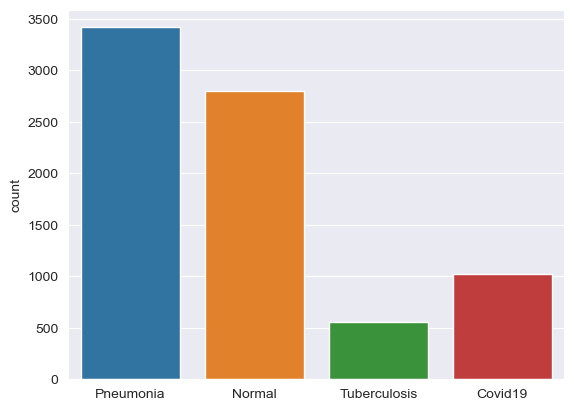

In [16]:
sns.set_style('darkgrid')
sns.countplot(x=l)

Text(0.5, 1.0, 'COVID19')

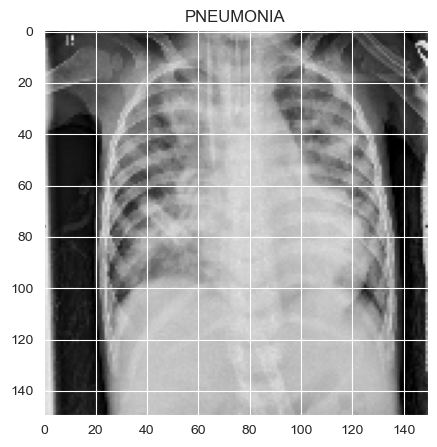

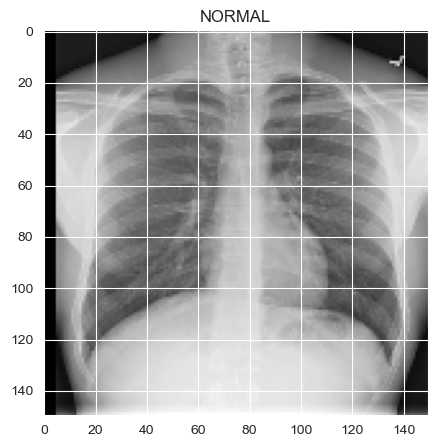

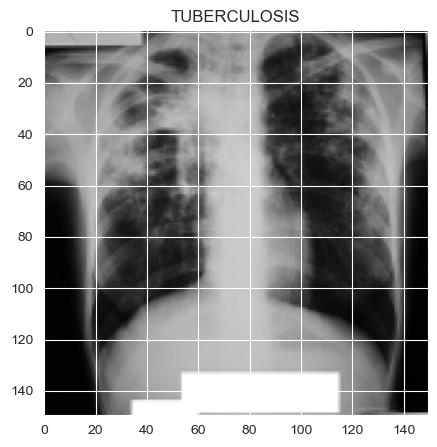

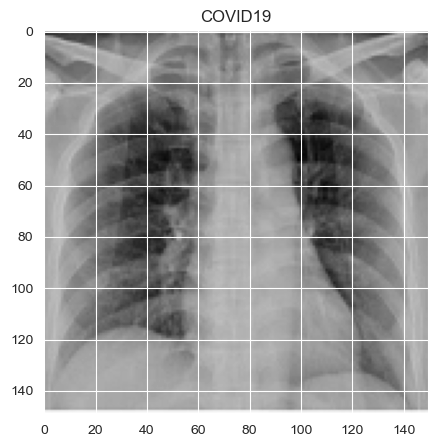

In [7]:
# Previewing an image from each class

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[3600][0], cmap='gray')
plt.title(labels[train[3600][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[6500][0], cmap='gray')
plt.title(labels[train[6500][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [8]:
# Split the data into features and labels

x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [9]:
# Accessing the no. of elements of each class in train, test, and val respectively

from collections import Counter

def get_element_frequency(arr):
    frequency_counter = Counter(arr)
    return frequency_counter

for i in (y_train,y_test,y_val):
    frequency = get_element_frequency(i)
    for element, count in frequency.items():
        print(f"The element {element} appears {count} times.")
    print()

The element 0 appears 3419 times.
The element 1 appears 2800 times.
The element 2 appears 560 times.
The element 3 appears 1025 times.

The element 0 appears 427 times.
The element 1 appears 350 times.
The element 2 appears 70 times.
The element 3 appears 128 times.

The element 0 appears 427 times.
The element 1 appears 350 times.
The element 2 appears 70 times.
The element 3 appears 128 times.



In [10]:
num_test_samples = len(x_train)
print("Number of x_train samples:", num_test_samples)

num_test_samples = len(x_test)
print("Number of x_test samples:", num_test_samples)

num_test_samples = len(x_val)
print("Number of x_val samples:", num_test_samples)

Number of x_train samples: 7804
Number of x_test samples: 975
Number of x_val samples: 975


# 3. Data Preprocessing

**Normalization:** We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [11]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [12]:
# Resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

**Data Augmentation:** In order to avoid overfitting problem, we need to expand artificially our dataset. We can make the existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

For the data augmentation, we did :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

# 4. Model Training

In [14]:
# Building the model

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Adjust the number of classes here
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       256       
 hNormalization)                                                 
                                                        

In [15]:
len(model.layers)

20

In [16]:
# Model Architecture Visualization

from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [18]:
# Convert class vectors to binary class matrices (one-hot encoding)

y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [20]:
# Training the model

history = model.fit(x_train, y_train, batch_size=32, epochs=12, validation_data = x_val, y_val, callbacks=[learning_rate_reduction])

Epoch 1/12
244/244 [==============================] - 383s 2s/step - loss: 1.0762 - accuracy: 0.6875 - val_loss: 0.9359 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 2/12
244/244 [==============================] - 296s 1s/step - loss: 0.6829 - accuracy: 0.7594 - val_loss: 0.8620 - val_accuracy: 0.6656 - lr: 0.0010
Epoch 3/12
244/244 [==============================] - ETA: 0s - loss: 0.6023 - accuracy: 0.7837
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
244/244 [==============================] - 238s 976ms/step - loss: 0.6023 - accuracy: 0.7837 - val_loss: 1.0084 - val_accuracy: 0.6185 - lr: 0.0010
Epoch 4/12
244/244 [==============================] - 242s 991ms/step - loss: 0.4974 - accuracy: 0.8159 - val_loss: 2.9724 - val_accuracy: 0.3631 - lr: 3.0000e-04
Epoch 5/12
244/244 [==============================] - 376s 2s/step - loss: 0.4423 - accuracy: 0.8375 - val_loss: 0.4173 - val_accuracy: 0.8390 - lr: 3.0000e-04
Epoch 6/12
244/244 [=========================

In [ ]:
#from tensorflow.keras.models import load_model

#model = load_model(' ')

In [21]:
print("Loss of the model is - ", model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", model.evaluate(x_test, y_test)[1] * 100, "%")

31/31 [==============================] - 12s 371ms/step - loss: 2.0004 - accuracy: 0.5774
Loss of the model is -  2.0003719329833984
31/31 [==============================] - 12s 374ms/step - loss: 2.0004 - accuracy: 0.5774
Accuracy of the model is -  57.74359107017517 %


In [ ]:
# model.save("Model of Jv2.11 [95.48% acc] Dataset 5.0, 20 epoch.h5")

# 5. Post-Training Analysis:

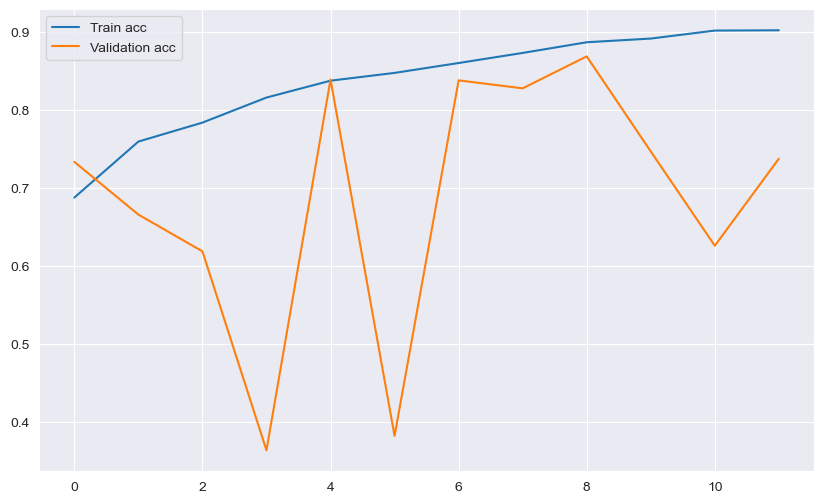

In [22]:
plt.figure(figsize=[10,6])
plt.plot(history.history["accuracy"], label = "Train acc")
plt.plot(history.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

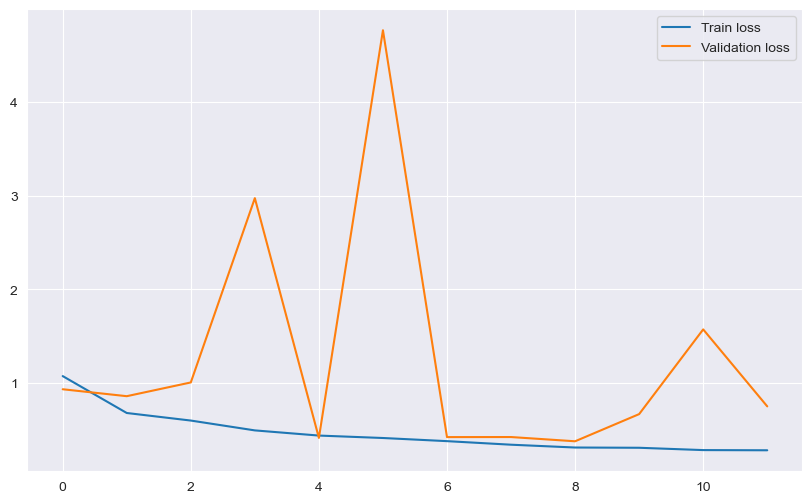

In [23]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label = "Train loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

In [24]:
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)  # Convert predictions to class labels
true_labels = np.argmax(y_test, axis=1)  # Convert true labels to class labels

31/31 [==============================] - 12s 363ms/step


In [25]:
print(classification_report(true_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

   PNEUMONIA       0.96      0.94      0.95       427
      NORMAL       0.64      0.05      0.09       350
TUBERCULOSIS       1.00      0.27      0.43        70
     COVID19       0.24      0.98      0.39       128

    accuracy                           0.58       975
   macro avg       0.71      0.56      0.46       975
weighted avg       0.76      0.58      0.53       975



# 6. Confusion Matrix

In [26]:
cm = confusion_matrix(true_labels, predicted_labels)
cm

array([[403,   0,   0,  24],
       [  1,  16,   0, 333],
       [ 11,   9,  19,  31],
       [  3,   0,   0, 125]], dtype=int64)

In [27]:
cm = pd.DataFrame(cm, index=labels, columns=labels)

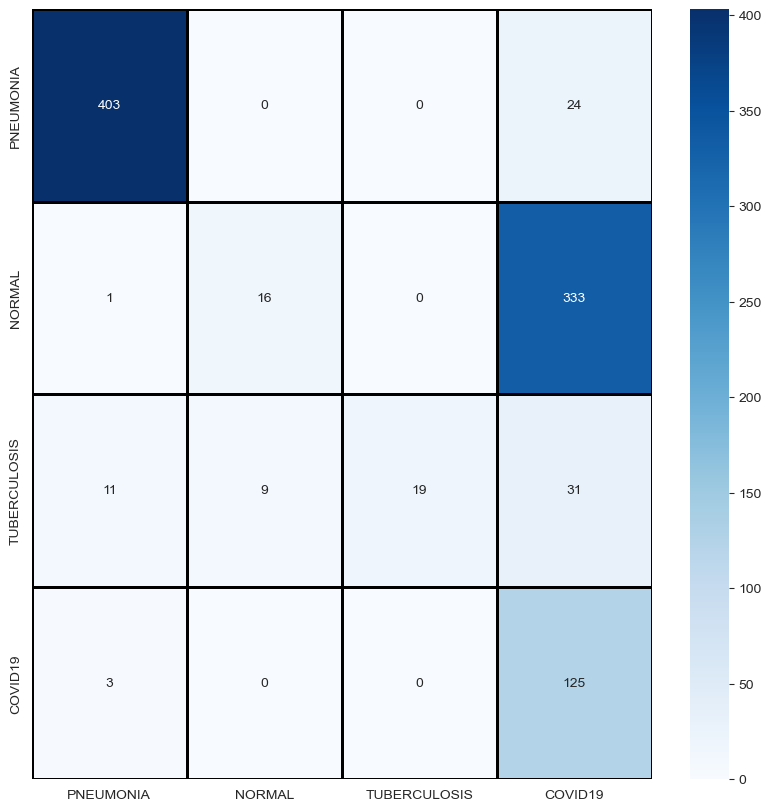

In [28]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)
plt.show()

# 7. Visualizing the predicted images

In [ ]:
correct = np.nonzero(predicted_labels == true_labels)[0]
incorrect = np.nonzero(predicted_labels != true_labels)[0]

In [ ]:
correct

In [ ]:
correct.size

In [ ]:
incorrect

In [ ]:
incorrect.size

In [ ]:
# Visualize correctly classified images

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Correctly Classified Images', fontsize=16)
for i, idx in enumerate(correct[:6]):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(x_test[idx].reshape(img_size, img_size), cmap="gray", interpolation='none')
    axes[row, col].set_title("Predicted Class: {}\nTrue Class: {}".format(labels[predicted_labels[idx]], labels[true_labels[idx]]))
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize incorrectly classified images

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.suptitle('Incorrectly Classified Images', fontsize=16)
for i, idx in enumerate(incorrect[:6]):
    row = i // 3
    col = i % 3
    axes[row, col].imshow(x_test[idx].reshape(img_size, img_size), cmap="gray", interpolation='none')
    axes[row, col].set_title("Predicted Class: {}\nTrue Class: {}".format(labels[predicted_labels[idx]], labels[true_labels[idx]]))
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

# 8. Random Predictions

In [ ]:
image = "C:\\Users\ACER\\Desktop\\Jupyter\\Project v2 (PNCT)\\v2 Dataset 5.0 (Imbalanced)\\test\\COVID19\\COVID-19 (1034).JPG"
def preprocess_image(image_path):
    img_arr = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_arr = cv2.resize(img_arr, (img_size, img_size))
    preprocessed_img = np.array(resized_arr) / 255.0
    preprocessed_img = preprocessed_img.reshape(-1, img_size, img_size, 1)
    return preprocessed_img

# Assuming 'image' is the variable containing the path to the image you want to predict
preprocessed_img = preprocess_image(image)
prediction = model.predict(preprocessed_img)
predicted_class = labels[np.argmax(prediction)]
print("Predicted class:", predicted_class)